In [144]:
import numpy as np
import scipy as sp
import os
import glob
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
%matplotlib inline

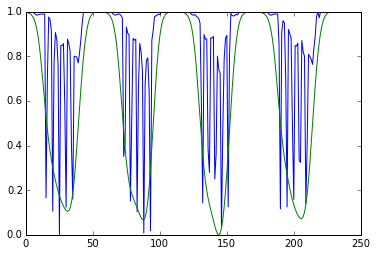

[  0  55 112 170 238]


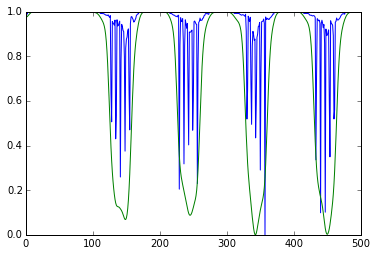

[  0 203 292 392 490]


In [145]:
def find_staves(songM):
    def project_to_left(matrix):
        vector = np.sum(matrix,axis=1)
        return vector
    
    def norm_vec(vec):
        vec = vec-min(vec)
        if max(vec) == 0:
            return vec
        return vec/float(max(vec))
        
    def smooth(vec,zahl):
        if zahl == 0:
            return vec
        vec = np.append([(2*vec[0] + vec[1])/3], [(vec[:-2] + 2*vec[1:-1] + vec[2:])/4])
        vec = np.append(vec,[(2*vec[-1] + vec[-2])/3])
        vec_smooth = smooth(vec,zahl-1)
        return vec_smooth
        
    def find_minima(vec):
        indices_minima = argrelextrema(vec, np.greater)
        return indices_minima
    
    def separate_to_staves(matrix, indices_minima):
        index_left = indices_minima[0]
        for zahl,index_right in enumerate(indices_minima[1:]):
            part = matrix[index_left:index_right,:]
            if not os.path.exists('lines'):
                os.makedirs('lines')
            num_files = len(glob.glob('lines/*.jpg'))
            sp.misc.imsave('lines/line%02i.jpg' % num_files, part)
            index_left = index_right
    
    tryer = project_to_left(songM)
    tryer = norm_vec(tryer)
    plt.plot(tryer)
    
    tryer = smooth(tryer,30)
    tryer = norm_vec(tryer)
    plt.plot(tryer)
    plt.show()
    
    index_minima = np.append(0,np.asarray(find_minima(tryer))[0])
    print index_minima
    separate_to_staves(songM,index_minima)   


shutil.rmtree('lines')
for song_file in glob.glob('songs/*.jpg'):
    song = Image.open(song_file).convert('L')
    songM = np.asarray(song)
    find_staves(songM)

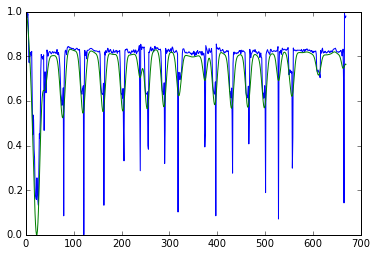

[  0  37  58  93 137 176 185 225 244 272 304 335 360 383 408 448 479 515
 540 572 587 645 668]


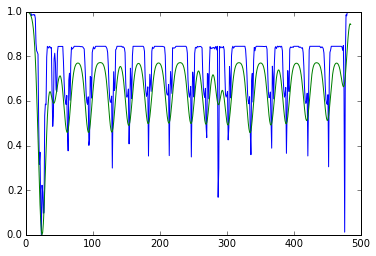

[  0  36  51  78 111 141 168 198 230 258 279 293 318 350 377 404 434 464
 484]


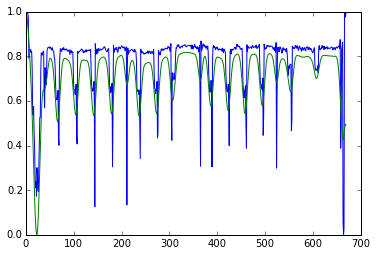

[  0  38  51  81 119 125 162 199 222 257 293 333 374 401 442 477 509 537
 567 588 623 646 668]


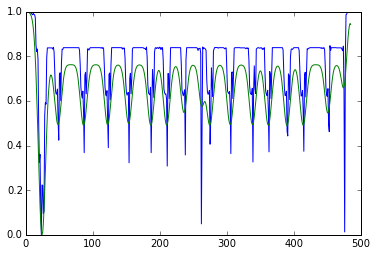

[  0  37  67 104 137 170 198 224 250 267 290 321 350 376 402 433 464 484]


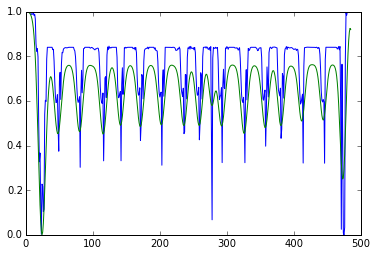

[  0  37  64  96 129 156 186 218 247 269 284 308 341 369 396 427 458 484]


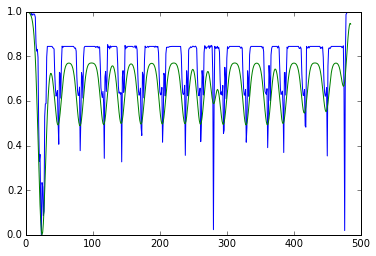

[  0  37  64  98 129 157 188 221 249 272 286 312 345 372 400 432 463 484]


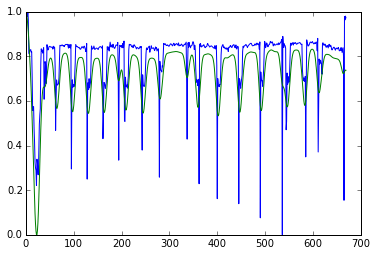

[  0  37  52  82 115 149 180 200 225 263 314 347 381 417 432 470 513 565
 598 629 668]


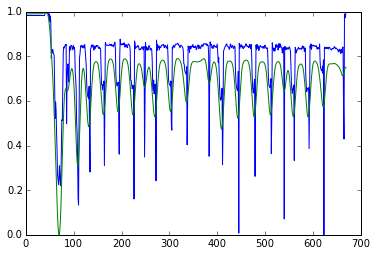

[  0  42  83  96 120 147 177 206 237 257 286 317 351 372 393 425 461 493
 527 548 575 604 636 644 668]


In [146]:
def find_notes(lineM):
    def project_to_bottom(matrix):
        vector = np.sum(matrix,axis=0)
        return vector
    
    def norm_vec(vector):
        vector = vector-min(vector)
        if max(vector) == 0:
            return vector
        return vector/float(max(vector))
        
    def smooth(vec,zahl):
        if zahl == 0:
            return vec
        vec = np.append([(2*vec[0] + vec[1])/3], [(vec[:-2] + 2*vec[1:-1] + vec[2:])/4])
        vec = np.append(vec,[(2*vec[-1] + vec[-2])/3])
        vec_smooth = smooth(vec,zahl-1)
        return vec_smooth
        
    def find_minima(vector):
        indices_minima = argrelextrema(vector, np.greater)
        return indices_minima
    
    def separate_to_notes(matrix, indices_minima):
        index_left = indices_minima[0]
        for zahl,index_right in enumerate(indices_minima[1:]):
            part = matrix[:,index_left:index_right]
            if not os.path.exists('lines/notes'):
                os.makedirs('lines/notes')
            num_files = len(glob.glob('lines/notes/*.jpg'))
            sp.misc.imsave('lines/notes/note%02i.jpg' % num_files, part)
            index_left = index_right
    
    tryer = project_to_bottom(lineM)
    tryer = norm_vec(tryer)
    plt.plot(tryer)
    
    tryer = smooth(tryer,30)
    tryer = norm_vec(tryer)
    plt.plot(tryer)
    plt.show()
    
    index_minima = np.append(0,np.asarray(find_minima(tryer))[0])
    print index_minima
    
    separate_to_notes(lineM,index_minima)
    
    
for line_file in glob.glob('lines/*.jpg'):
    line = Image.open(line_file)
    lineM = np.asarray(line)
    find_notes(lineM)

In [147]:
def equalize(note):
    width = 25
    hight = 50
    
    def ensure_filesize(matrix):
        up_plus = matrix[:1,:]
        up_plus = np.append(np.append(np.append(np.append(up_plus,up_plus,axis=0),up_plus,axis=0),up_plus,axis=0),up_plus,axis=0)
        matrix = np.append(up_plus,matrix,axis=0)
        low_plus = matrix[-1:,:]
        low_plus = np.append(np.append(np.append(np.append(low_plus,low_plus,axis=0),low_plus,axis=0),low_plus,axis=0),low_plus,axis=0)
        matrix = np.append(matrix,low_plus,axis=0)
        left_plus = matrix[:,:1]
        left_plus = np.append(np.append(np.append(np.append(left_plus,left_plus,axis=1),left_plus,axis=1),left_plus,axis=1),left_plus,axis=1)
        matrix = np.append(left_plus,matrix,axis=1)
        right_plus = matrix[:,-1:]
        right_plus = np.append(np.append(np.append(np.append(right_plus,right_plus,axis=1),right_plus,axis=1),right_plus,axis=1),right_plus,axis=1)
        matrix = np.append(matrix,right_plus,axis=1)
        return matrix
        
    def shrink_to_size(matrix):
        index_left = matrix.shape[1]/2 - width/2
        index_right = matrix.shape[1]/2 + width/2        
        index_low = matrix.shape[0]/2 - hight/2
        index_up = matrix.shape[0]/2 + hight/2
        return matrix[index_low:index_up,index_left:index_right]
        
    note = ensure_filesize(note)
    note = shrink_to_size(note)
    return note
    
   
for note_file in glob.glob('lines/notes/*.jpg'):
    note = Image.open(note_file)
    note = np.asarray(note)
    note = equalize(note)
    sp.misc.imsave(note_file, note)
    